In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

In [14]:
sneakers = pd.read_csv("C:/Users/aayus/Downloads/2019 Winter Data Science Intern Challenge Data Set.csv")

In [15]:
#Quick look at the dataset
sneakers.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [16]:
#Check to ensure we are seeing all columns
sneakers.columns


Index(['order_id', 'shop_id', 'user_id', 'order_amount', 'total_items',
       'payment_method', 'created_at'],
      dtype='object')

In [17]:
#Check data types
sneakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [18]:
#Check the structure of the dataset
sneakers.shape

(5000, 7)

In [19]:
#Viewing descriptive statistics of two columns
sneakers[['order_amount', 'total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


<AxesSubplot:>

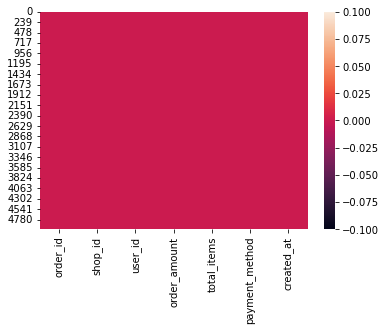

In [20]:
#Check if data has nulls
sns.heatmap(sneakers.isnull())

In [21]:
null_check = sneakers.isnull().sum().to_frame()
null_check.columns = ['number_null']
null_check

,number_null
order_id,0
shop_id,0
user_id,0
order_amount,0
total_items,0
payment_method,0
created_at,0


After our EDA, we can now start with our resolutions to this analysis problem

# Section 1: Scale orders to 1 item purchased and engineer new feature

In [22]:
#Filter necessary columns for analysis
sneakers_s1 = sneakers.copy()
sneakers_s1 = sneakers_s1[['shop_id', 'order_amount', 'total_items']]

In [23]:
#Scale purchases to give even weight to total_items
sneakers_s1['orders_to_one'] = sneakers_s1['order_amount'] / sneakers_s1['total_items']

Now we have a column that represents order amount spent, if each customer only bought one item

In [24]:
sneakers_s1.head()

,shop_id,order_amount,total_items,orders_to_one
0,53,224,2,112.0
1,92,90,1,90.0
2,44,144,1,144.0
3,18,156,1,156.0
4,18,156,1,156.0


In [26]:
#We can now compute average order value for the dataset
np.mean(sneakers_s1['orders_to_one'])

387.7428

But wait, why is the average still very high? Let's observe the how much each shop is selling the shoe, and see if someone is overpicing or underpricing

In [27]:
sneakers_s1.groupby(sneakers_s1['shop_id'])['orders_to_one'].mean().reset_index().sort_values(by=['orders_to_one'], ascending = False).head()

,shop_id,orders_to_one
77,78,25725.0
41,42,352.0
11,12,201.0
88,89,196.0
98,99,195.0


Therefore, we reveal that shop 78 is overpricing, as to why the average is still high.

In [28]:
#Average after removing shop 78 from calculation
np.mean(sneakers_s1[sneakers_s1['shop_id'] != 78]['orders_to_one'])

152.47557529269278

To conclude, it looks like our shoe is affordable, at an average of $152.48 per shoe across 99 stores

# Section 2: Remove anomalies and re-evaluate average order value


Let's observe two columns: order_amount & total_items



In [29]:
sneakers_s2 = sneakers.copy()

Visualize order_amount using histogram

Text(0, 0.5, 'Count')

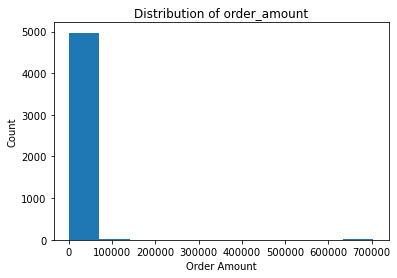

In [30]:
plt.hist(sneakers_s2['order_amount'])
plt.title('Distribution of order_amount')
plt.xlabel('Order Amount')
plt.ylabel('Count')

We have already seen above that shop 78 is the issue, so we can filter shop 78 at the end.

In [31]:
#See number of orders at each amount of total items
sneakers_s2['total_items'].value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

In [32]:
#Which store is selling 2000 items per order?
sneakers_s2[sneakers_s2['total_items'] == 2000]['shop_id'].unique()

array([42], dtype=int64)

Is this the shop 42's issue or is it a customer that is driving high order amounts?


In [33]:
sneakers_s2 = sneakers_s2[['shop_id', 'user_id', 'order_amount', 'total_items']]

In [34]:
sneakers_s2[sneakers_s2['shop_id'] == 42].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
40,42,793,352,1
60,42,607,704000,2000
308,42,770,352,1
409,42,904,704,2


In [35]:
sneakers_s2[sneakers_s2['user_id'] == 607].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
60,42,607,704000,2000
520,42,607,704000,2000
1104,42,607,704000,2000
1362,42,607,704000,2000


The reason we remove shop 42 although the anomalies are caused by customer 607 is because as a business, we cannot control how the consumer spends. We can only change how the business acts, removing this customer to strengthen our model for a better understanding of the problem.

In [36]:
#After removing both shop 78 and 42
filtered_dataset = sneakers[(sneakers['shop_id'] != 42) & (sneakers['shop_id'] != 78)]


In [37]:
# Average amount per order
np.mean(filtered_dataset['order_amount'])

300.1558229655313

In [38]:
# Average items per order
np.mean(filtered_dataset['total_items'])


1.9957169080155006

To conclude, the average order amount is roughly $300.16, considering that some consumers purchase more than 1 order per visit.
This is not an indicator of shoe affordability.


# Section 3: Use new metrics

Let's assume we don't want to remove any shops, but rather introduce a new metric to analyze the data

In [39]:
sneakers_s3 = sneakers.copy()

Let's use a different metric to understand anomalies, such as percentile

In [40]:
sneakers_s3['order_amount'].describe().to_frame().round(2)

,order_amount
count,5000.00
mean,3145.13
std,41282.54
min,90.00
25%,163.00
50%,284.00
75%,390.00
max,704000.00


Quick observations
1. Mean is what we expected
2. Standard deviation is very high, which indicates large differences in order amount
3. 75% percentile represents accurately; it makes sense because some consumers purchase more than one item

C:\Users\aayus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='order_amount'>

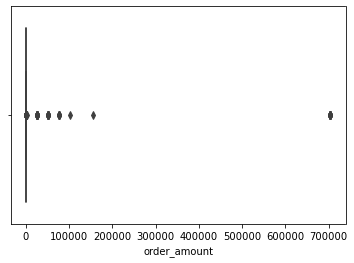

In [41]:
# The boxplot below does not show values due to the anomalies
sns.boxplot(sneakers_s3['order_amount'])

In [42]:
#Feature Engineering from describe() table above
sneakers_s3['z_score'] = (sneakers_s3['order_amount'] - 3145.13) / 41282.54
sneakers_s3['z_score'] = sneakers_s3['z_score'].round(3)
sneakers_s3.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,z_score
0,1,53,746,224,2,cash,2017-03-13 12:36:56,-0.071
1,2,92,925,90,1,cash,2017-03-03 17:38:52,-0.074
2,3,44,861,144,1,cash,2017-03-14 4:23:56,-0.073
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,-0.072
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,-0.072


The initial z-score looks accurate, let's see the ones that are slighly further from the mean

In [43]:
sneakers_s3[sneakers_s3['z_score'] > 0.1].head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,z_score
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,16.977
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,16.977
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,0.547
490,491,78,936,51450,2,debit,2017-03-26 17:08:19,1.170
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,1.170


We observed back in section 1 and section 2 that shops 78 and 42 were causing us issues. Let's see if this applies for z-score of above 0.1


In [44]:
sneakers_s3[abs(sneakers_s3['z_score']) > 0.1]['shop_id'].unique()

array([42, 78], dtype=int64)

Once again, we see that 78 and 42 have anomalous behaviour. However, we now have an interpretation of the whole dataset using .describe() and an observation of each independent order using z-score. We can use both these metrics for different use cases.